In [1]:
from datetime import datetime
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
import re
import statsmodels.formula.api as sm
from tqdm import tqdm

In [2]:
data_directory = '../clean-data/'

usgs_df = pd.read_csv( f'{data_directory}/usgs-data.csv' )
location_codes = pd.read_csv( f'{data_directory}/location-data.csv' ).drop_duplicates()
generation_df = pd.read_csv( f'{data_directory}/dam-release.csv' )

location_roswell = location_codes[location_codes.location_name.str.contains( 'ABOVE ROSWELL' )].iloc[0]

#
# Error check
#
display(
    usgs_df \
        [['datetime']] \
        .assign( count = 1 ) \
        .groupby( 'datetime' ) \
        .count() \
        .reset_index() \
        [lambda _df: _df['count'] > 1]
)
usgs_df = usgs_df[~usgs_df.datetime.str.startswith( '2024-11-03 01:' )].reset_index( drop = True )

,datetime,count
230,2024-11-03 01:00,128
231,2024-11-03 01:15,128
232,2024-11-03 01:30,128
233,2024-11-03 01:45,128


# Relationship between flow rate and gage height

When we plot flow rate v. gage height, it looks like marginal gage height is decreasing in flow rate. This could be consistent with the following setup:
$$
\text{Total flow} = \text{Cross section} \times \text{Flow speed}
$$
Of course, $\text{Cross section} \propto \text{Gage height}^2$. We may take $\text{Flow speed} \approx C$. This gives
$$
\text{Gage height} = \alpha \times \sqrt{\text{Total flow}} + \varepsilon.
$$
Below we compute $\alpha$.

**Conclusion.** We can ignore gage height and just predict flow rate.

_Note._ It is more likely that $\text{Flow speed} \propto C' + \text{Total flow}$, but the simpler model seems to fit well enough.

AttributeError: module 'matplotlib.pyplot' has no attribute 'writepng'

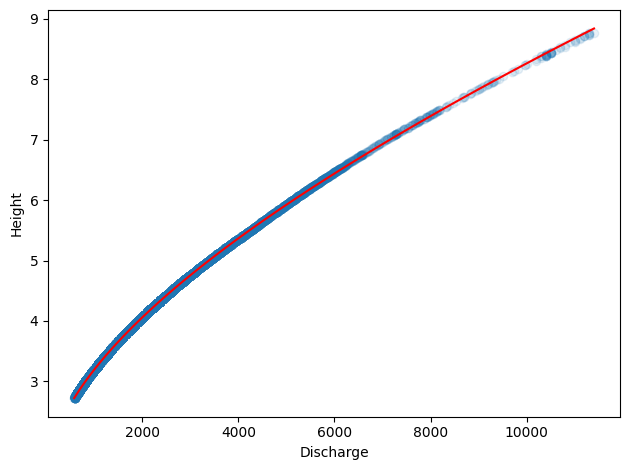

In [ ]:
data_x = f'discharge_{location_roswell.location_code:08d}'
data_y = f'gage_height_{location_roswell.location_code:08d}'

plot_df = usgs_df[['datetime',data_x,data_y]]
height_reg_df = plot_df \
    .copy() \
    .assign(
        discharge = lambda _df: _df[data_x],
        discharge_2 = lambda _df: _df[data_x] ** 0.5,
        height = lambda _df: _df[data_y]
    )

plot.scatter( plot_df[data_x], plot_df[data_y], alpha = 0.1 )
plot.xlabel( 'Discharge' )
plot.ylabel( 'Height' )

height_ols = sm.ols( f'height ~ discharge + discharge_2', height_reg_df )
height_ols = height_ols.fit()

plot.draw()
x_range = np.linspace( start = plot_df[data_x].min(), stop = plot_df[data_x].max(), num = 100 )
plot.plot( x_range, height_ols.predict( pd.DataFrame( zip( x_range, x_range ** 0.5 ), columns = [ 'discharge', 'discharge_2' ] ) ), color = 'red' )
plot.tight_layout()
plot.writepng( '/.graphics/height_v_discharge.png' )
plot.show()

display( height_ols.summary() )

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     Zt   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.730e+06
Date:                Sat, 02 Aug 2025   Prob (F-statistic):                        0.00
Time:                        19:20:49   Log-Likelihood:                     -1.3057e+05
No. Observations:               24816   AIC:                                  2.612e+05
Df Residuals:                   24783   BIC:                                  2.615e+05
Df Model:                          33                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Zt_1           0.9692      0.000   4445.837      0.000       0.969       0.970
Yt_28          0.0333      0.001     45.140      0.000       0.032       0.035
Yt_29         -0.0261      0.002    -15.918      0.000      -0.029      -0.023
Yt_30          0.0263      0.002     12.630      0.000       0.022       0.030
Yt_31         -0.0124      0.002     -5.518      0.000      -0.017      -0.008
Yt_32          0.0127      0.002      5.663      0.000       0.008       0.017
Yt_33         -0.0050      0.002     -2.395      0.017      -0.009      -0.001
Yt_34          0.0033      0.002      1.974      0.048    2.34e-05       0.006
Yt_35          0.0015      0.001      1.924      0.054   -2.73e-05       0.003
P0t_0         89.2879     24.402      3.659      0.000      41.458     137.117
P0t_1         51.6059     26.020      1.983      0.047       0.605     102.606
P0t_2         69.2786     26.086      2.656      0.008      18.149     120.409
P0t_3         39.4446     26.161      1.508      0.132     -11.833      90.723
P0t_4         37.6897     29.941      1.259      0.208     -20.996      96.376
P0t_5         56.1853     30.029      1.871      0.061      -2.673     115.043
P0t_6         53.7488     30.217      1.779      0.075      -5.478     112.975
P0t_7         57.5194     29.928      1.922      0.055      -1.141     116.180
P1t_4         35.1960     29.335      1.200      0.230     -22.302      92.694
P1t_5         38.3454     29.938      1.281      0.200     -20.336      97.026
P1t_6         63.3993     30.012      2.112      0.035       4.574     122.225
P1t_7         92.9858     30.570      3.042      0.002      33.066     152.906
P1t_8        112.3690     31.199      3.602      0.000      51.218     173.520
P1t_9        153.6677     31.217      4.922      0.000      92.480     214.856
P1t_10       166.4649     31.090      5.354      0.000     105.527     227.403
P1t_11       181.5296     30.936      5.868      0.000     120.892     242.167
P2t_8         33.1572     30.169      1.099      0.272     -25.977      92.291
P2t_9         38.6316     30.300      1.275      0.202     -20.758      98.021
P2t_10        49.8165     30.339      1.642      0.101      -9.649     109.282
P2t_11        32.3581     30.372      1.065      0.287     -27.173      91.889
P2t_12       128.5511     26.348      4.879      0.000      76.907     180.195
P2t_13       169.0240     25.446      6.642      0.000     119.148     218.900
P2t_14       153.5900     25.377      6.052      0.000     103.850     203.330
P2t_15       165.6668     23.354      7.094      0.000     119.892     211.442
==============================================================================
Omnibus:                    10244.238   Durbin-Watson:       

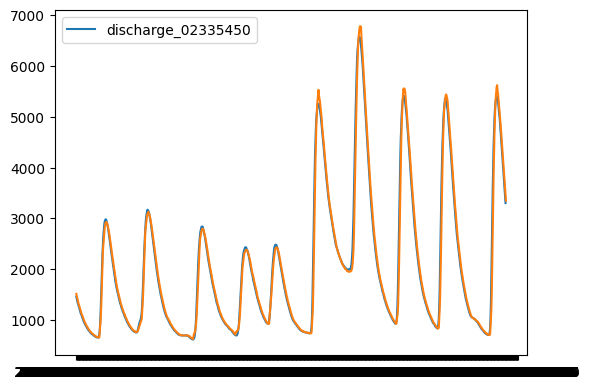

In [429]:
# the gap seems to be ~21:15 -> 04:15, so ~7 hours or 28 spots

location_buford_dam = '02334430'
location_above_roswell = f'{location_roswell.location_code:08d}'

observation_delay = 28
observation_window = 8

data_x = f'discharge_{location_buford_dam}'
data_y = f'discharge_{location_above_roswell}'

plot_tail_points = 1000

precip_cols = [ column for column in usgs_df if column[:8] == 'precipit' ]
plot_df = usgs_df[['datetime',data_x,data_y,*precip_cols]]
reg_df = plot_df \
    .tail( int( 25e3 ) ) \
    .rename( columns = { data_y: 'Zt', data_x: 'Yt_0' } ) \
    .assign( Zt_1 = lambda _df: _df.Zt.shift( 1 ) ) \
    .assign( Zt_2 = lambda _df: _df.Zt.shift( 2 ) )
plot_df = plot_df.tail( plot_tail_points )

figure, axes = plot.subplots()
figure.set_size_inches( 6, 4 )

# axes.plot( plot_df['datetime'], plot_df[data_x], label = data_x )
axes.plot( plot_df['datetime'], plot_df[data_y].shift( -28 ), label = data_y )
axes.legend( loc = 'best' )

eqn = ''
for dt in range( observation_delay, observation_delay + observation_window ):
    colname = f'Yt_{dt:0d}'
    reg_df = reg_df \
        .assign( **{ colname: reg_df.Yt_0.shift( dt ) } ) \
        .assign( **{ f'{colname}_2': lambda _df: ( _df[colname] / _df[colname].mean() ) ** 2 } )
    eqn = f'{eqn} + {colname}'

for ix, colname in enumerate( precip_cols ):
    for dt in range( 0 + 4 * ix, 8 + 4 * ix ):
        precip_col_shifted = f'P{ix}t_{dt}'
        reg_df = reg_df.assign( **{ precip_col_shifted: reg_df[colname].shift( dt ) } )
        eqn = f'{eqn} + {precip_col_shifted}'

ols = sm.ols( f'Zt ~ 0 + Zt_1 + {eqn}', data = reg_df )
ols = ols.fit()
display( ols.summary() )

# reg_df = reg_df.tail( plot_tail_points )

plot.plot( reg_df['datetime'].tail( plot_tail_points ), ols.predict( reg_df.tail( plot_tail_points ) ).shift( -27 ), label = 'prediction' )

plot.tight_layout()
plot.show()


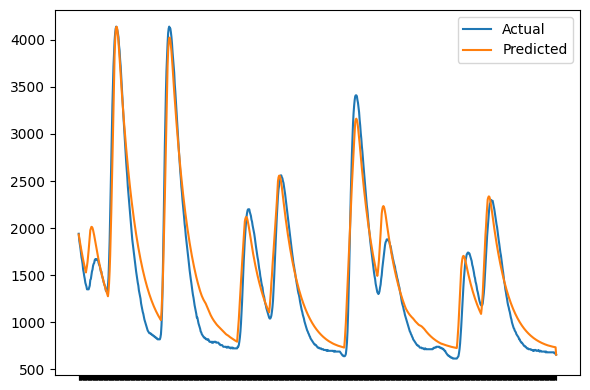

In [454]:
def iterative_predict( date_str, steps = 4 * 24 ):
    ix0 = int( np.min( reg_df[reg_df.datetime.str.startswith( date_str )].index ) - 1 )
    pred_df = reg_df.loc[ix0:(ix0 + steps + 1)].copy().assign( Zt_actual = lambda _df: _df.Zt )

    # predictions = [ np.nan ]
    for ix in tqdm( range( ix0, ix0 + steps + 1 ) ):
        pred_df.loc[ix,'Zt'] = ols.predict( pred_df.loc[[ix]] ).iloc[0]
        pred_df.loc[ix+1,'Zt_1'] = pred_df.loc[ix,'Zt']

    return pred_df



def clean_xaxis ( axes ):
    plot.draw()

    xticks = axes.get_xticks()
    xticklabels = axes.get_xticklabels()

    desired_label_count = 10
    label_count = 0
    num_hours = 1

    while label_count < desired_label_count:
        hours = list( [ f'{hour:02.0f}' for hour in range( 24, 24 // num_hours ) ] )
        keep_labels = [ label for label in xticklabels if label.get_text().split( ' ' )[:2] in hours ]

        if len( keep_labels ) > desired_label_count:
            break

        num_hours *= 2
        if num_hours > 24:
            break

    axes.set_xticks( [ label.x for label in keep_labels ] )
    axes.set_xticklabels( keep_labels )



#
# res = iterative_predict( '2025-03-18', steps = 9 * 4 * 24 )
figure, axes = plot.subplots()
figure.set_size_inches( 6, 4 )

axes.plot( res.datetime, res.Zt_actual, label = 'Actual' )
axes.plot( res.datetime, res.Zt, label = 'Predicted' )

axes.legend( loc = 'best' )
clean_xaxis( axes )

# plot.scatter( res.Zt_0, res.Zt_0_hat )
plot.tight_layout()
plot.show()

In [478]:
axe 

<AxesSubplot:>

In [365]:
#
# Take care of regression
#
gen_reg_df = generation_df.merge( fdf ) \
    [['datetime','discharge_02334430','generation']] \
    .rename( columns = { 'discharge_02334430': 'discharge' } ) \
    .assign(
        discharge_1 = lambda _df: _df.discharge.shift( 1 ),
        generation_1 = lambda _df: _df.generation.shift( 1 ),
        generation_2 = lambda _df: _df.generation.shift( 2 )
    )

gen_ols = sm.ols( 'discharge ~ generation_1 + generation_2 + discharge_1', data = gen_reg_df )
gen_ols = gen_ols.fit()

gen_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              discharge   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.553e+05
Date:                Tue, 29 Jul 2025   Prob (F-statistic):               0.00
Time:                        09:47:41   Log-Likelihood:                -2675.2
No. Observations:                 435   AIC:                             5358.
Df Residuals:                     431   BIC:                             5375.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -23.2535      6.448     -3.606      0.000     -35.928     -10.579
generation_1    30.5511      0.380     80.479      0.000      29.805      31.297
generation_2    29.3778      0.638     46.019      0.000      28.123      30.633
discharge_1      0.3658      0.006     66.059      0.000       0.355       0.377
==============================================================================
Omnibus:                       92.495   Durbin-Watson:                   1.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2142.122
Skew:                           0.022   Prob(JB):                         0.00
Kurtosis:                      13.871   Cond. No.                     5.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

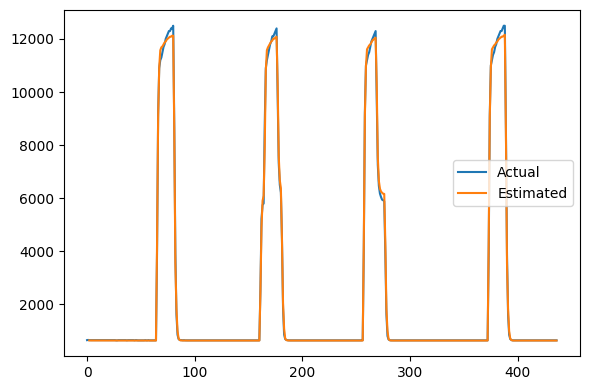

In [366]:
figure, axes = plot.subplots()
figure.set_size_inches( 6, 4 )

axes.plot( gen_reg_df.index, gen_reg_df.discharge, label = 'Actual' )
axes.plot( gen_reg_df.index, gen_ols.predict( gen_reg_df ), label = 'Estimated' )

axes.legend( loc = 'best' )

plot.tight_layout()
plot.show()

In [377]:
def iterative_predict ( model, df, column, shifts = [], backtrack = 0 ):
    ix_0 = np.min( df[pd.isnull( df[column] )].index )
    ix_0 = max( 0, ix_0 - backtrack )

    for ix in tqdm( range( ix_0, len( df ) ) ):
        for shift_col, shift_amt in shifts:
            df.loc[ix,f'{shift_col}_{shift_amt}'] = df.loc[ix - shift_amt,shift_col]

        df.loc[ix,column] = model.predict( df.loc[[ix]].fillna( 0 ) ).iloc[0]

    return df



generation_pred_df = generation_df \
    .merge( fdf, on = 'datetime', how = 'left' ) \
    [['datetime','discharge_02334430','generation']] \
    .rename( columns = { 'discharge_02334430': 'discharge' } ) \
    .assign(
        discharge_1 = lambda _df: _df.discharge.shift( 1 ),
        generation_1 = lambda _df: _df.generation.shift( 1 ),
        generation_2 = lambda _df: _df.generation.shift( 2 )
    ) \
    .assign( discharge_actual = lambda _df: _df.discharge ) \
    .sort_values( 'datetime' ) \
    .reset_index( drop = True )

generation_pred_df = iterative_predict( gen_ols, generation_pred_df, 'discharge', [ ( 'discharge', 1 ) ] )
final_pred_df = generation_pred_df \
    .merge( reg_df, on = 'datetime', how = 'left' ) \
    .assign( Zt_actual = lambda _df: _df.Zt )

for y_column in [ column for column in final_pred_df if column[:2] == 'Yt' ]:
    shift = int( y_column.split( '_' )[1] )
    colname = f'Yt_{shift:0d}'
    final_pred_df = final_pred_df \
        .assign( **{ f'Yt_{shift}_old': lambda _df: _df[y_column] } ) \
        .assign( **{ colname: lambda _df: _df.discharge.shift( shift ) } ) \
        .assign( **{ f'{colname}_2': lambda _df: ( _df[colname] / _df[colname].mean() ) ** 2 } )

final_pred_df = iterative_predict( ols, final_pred_df, 'Zt', [ ( 'Zt', 1 ), ( 'Zt', 2 ) ], backtrack = 4 * 6 )

100%|██████████| 259/259 [00:03<00:00, 68.66it/s]


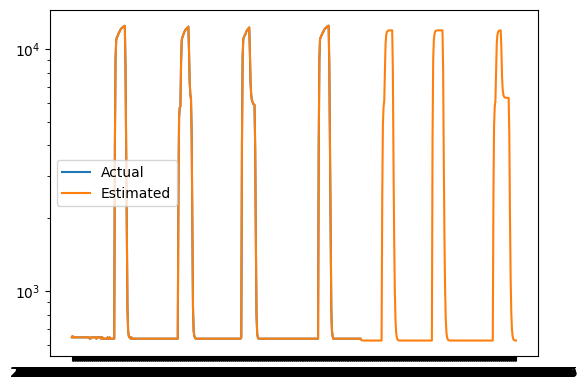

In [372]:
figure, axes = plot.subplots()
figure.set_size_inches( 6, 4 )

axes.plot( generation_pred_df.datetime, generation_pred_df.discharge_actual, label = 'Actual' )
axes.plot( generation_pred_df.datetime, generation_pred_df.discharge, label = 'Estimated' )
axes.set_yscale( 'log' )

axes.legend( loc = 'best' )

plot.tight_layout()
plot.show()

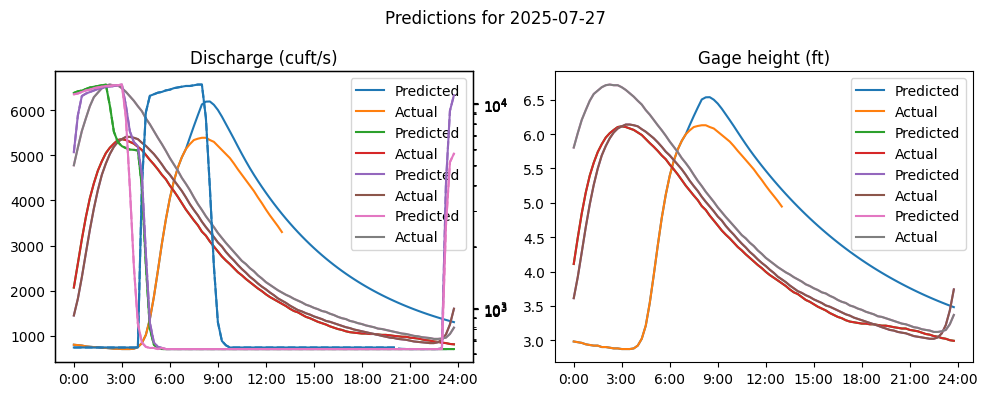

In [380]:
def plot_date ( preds, dt = None, height_model = height_ols, axes = None ):
    if dt is None:
        dt = preds.datetime.max().split( ' ' )[0]

    plot_df = preds \
        .assign( D28_actual = lambda _df: _df.discharge_actual.shift( 28 ) ) \
        [preds.datetime.str.startswith( dt )] \
        .assign( datetime = lambda _df: _df.datetime.apply( lambda _dt: _dt.split( ' ' )[-1] ) )

    add_plot_suptitle = axes is None
    if axes is None:
        figure, axes = plot.subplots( 1, 2 )
        figure.set_size_inches( 10, 4 )

    patches = axes[0].plot( plot_df.datetime, plot_df.Zt, label = 'Predicted' )
    if np.any( ~pd.isnull( plot_df.Zt_actual ) ):
        axes[0].plot( plot_df.datetime, plot_df.Zt_actual, label = 'Actual' )
        axes[0].legend( loc = 'best' )

    axes_2 = axes[0].twinx()
    axes_2.plot( plot_df.datetime, plot_df.Yt_28, color = patches[0].get_color(), linestyle = 'dashed' )
    axes_2.plot( plot_df.datetime, plot_df.D28_actual, color = patches[0].get_color(), linestyle = 'solid' )
    axes_2.set_yscale( 'log' )

    axes[0].set_title( 'Discharge (cuft/s)' )

    axes[1].plot(
        plot_df.datetime,
        height_model.predict( plot_df.assign(
            discharge = lambda _df: _df.Zt,
            discharge_2 = lambda _df: _df.Zt ** 0.5
        ) ),
        label = 'Predicted'
    )
    if np.any( ~pd.isnull( plot_df.Zt_actual ) ):
        axes[1].plot(
            plot_df.datetime,
            height_model.predict( plot_df.assign(
                discharge = lambda _df: _df.Zt_actual,
                discharge_2 = lambda _df: _df.Zt_actual ** 0.5
            ) ),
            label = 'Actual'
        )
        axes[1].legend( loc = 'best' )
    axes[1].set_title( 'Gage height (ft)' )

    plot.draw()
    for axis in axes:
        axis.set_xticks( range( 0, 4 * 25, 4 * 3 ) )
        axis.set_xticklabels( [ f'{hh}:00' for hh in range( 0, 25, 3 ) ] )

    if add_plot_suptitle:
        plot.suptitle( f'Predictions for {dt}' )

    return axes, plot_df

axes, plot_df = plot_date( final_pred_df, dt = '2025-07-27' )#, dt = '2025-07-27' )
plot_date( final_pred_df, dt = '2025-07-26', axes = axes )
plot_date( final_pred_df, dt = '2025-07-25', axes = axes )
axes, plot_df = plot_date( final_pred_df, dt = '2025-07-24', axes = axes )

plot.tight_layout()
plot.show()